In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
import plotly.graph_objs as go
import plotly.express as px
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import scipy.stats as stats
from numpy import median
from numpy import std

from scipy import stats

## What is Hypothesis Testing

Hypothesis testing is an act in statistics with which an analyst tests an assumption regarding a population parameter. It is used extensively to assess the plausibility of a hypothesis by using sample data. The assumptions made might be correct or it may not be. Data alone isn't interesting enough. It is the interpretation that we are really interested in.

# **1. Getting familiar with data**

In [2]:
data = pd.read_csv("./marketing_data.csv")
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,2,7,1,0,0,0,0,1,0,SP


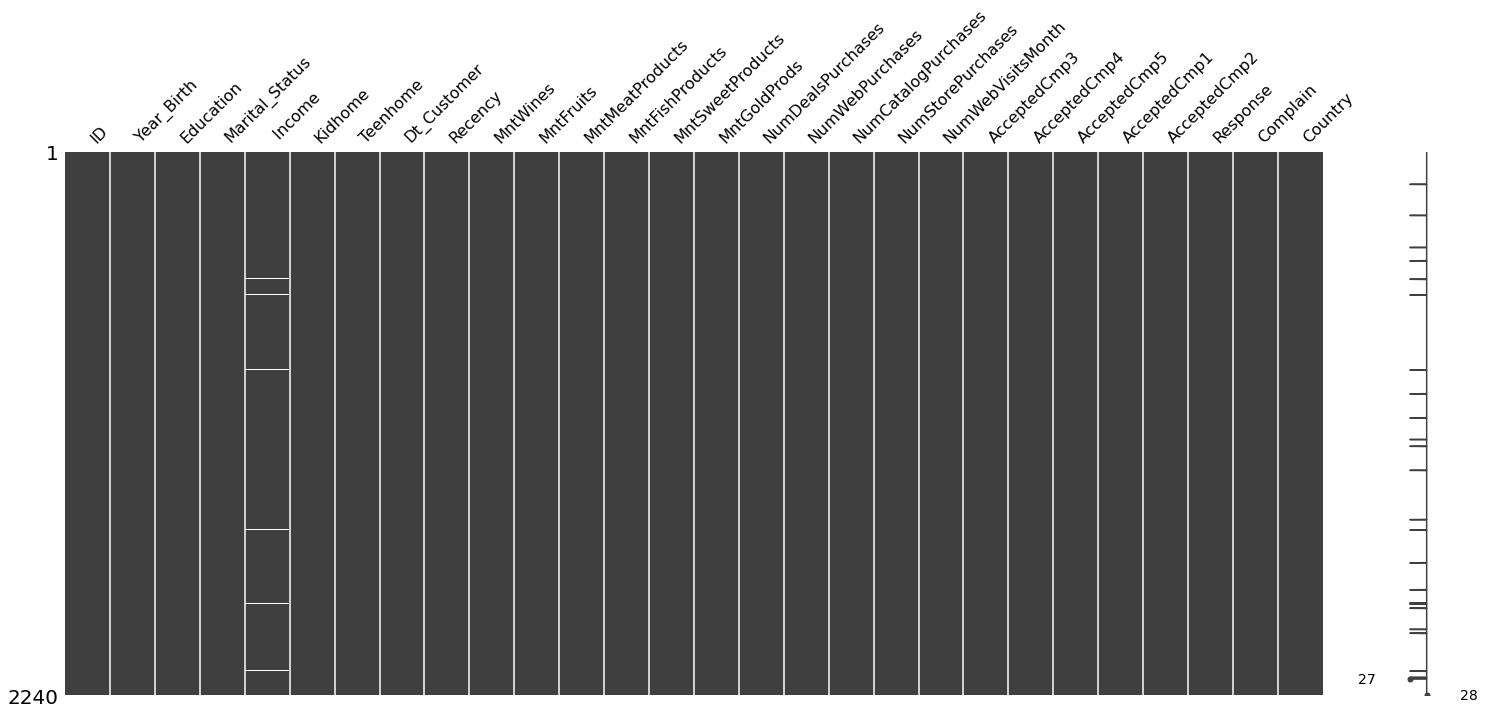

In [3]:
msno.matrix(data)
plt.show()

In [4]:
missing_value = data.isnull().sum()
print(missing_value.loc[missing_value!=0])

 Income     24
dtype: int64


**Using the info function, we can pull the following information from our dataset :**

We have **5** categorical variables and **23** numerical variables

We have missing values for the Income variable

We see that column_name **"Income"** has a space before it's name that will create problems in further analysis, so we'll rename it.


There looks a problem with 2 column's datatypes. We need to change the datatype of **"Income"** column into int64 so that it can be used for further calculations.

In [5]:
data.rename(columns={' Income ':'Income'},inplace=True)
data["Income"] = data["Income"].str.replace("$","").str.replace(',', '')
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,84835.00,0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,57091.00,0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,67267.00,0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,32474.00,1,1,5/11/14,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,21474.00,1,0,4/8/14,0,6,...,2,7,1,0,0,0,0,1,0,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,1976,PhD,Divorced,66476.00,0,1,3/7/13,99,372,...,11,4,0,0,0,0,0,0,0,US
2236,5263,1977,2n Cycle,Married,31056.00,1,0,1/22/13,99,5,...,3,8,0,0,0,0,0,0,0,SP
2237,22,1976,Graduation,Divorced,46310.00,1,0,12/3/12,99,185,...,5,8,0,0,0,0,0,0,0,SP
2238,528,1978,Graduation,Married,65819.00,0,0,11/29/12,99,267,...,10,3,0,0,0,0,0,0,0,IND


Having a first look at the row data enables us to start thinking at some useful variables we could create in order to better understand our dataset and reveal precious information.

**We wrill create several variables :**

Variable Age in replacement of the variable Year_birth

Variable Spending as the sum of the amount spent on the 6 product categories

Variable Marital_Situation to group the different marital status in only 2 comprehensive categories : In couple vs Alone

Variable Has_child as a binary variable equal to Yes if the customer has 1 child or more

Variable Educationnal_years as the total number of years of education the individual achieved according to its diploma

We will remove the unused variables for this analysis

In [6]:
data['Age']=2023-data['Year_Birth']
data['Spending']=data['MntWines']+data['MntFruits']+data['MntMeatProducts']+data['MntFishProducts']+data['MntSweetProducts']+data['MntGoldProds']
data['Marital_Situation']=data['Marital_Status'].replace({'Divorced':'Alone','Single':'Alone','Married':'In couple','Together':'In couple','Absurd':'Alone','Widow':'Alone','YOLO':'Alone'})
data['Has_child'] = np.where(data.Kidhome+data.Teenhome > 0, 'Yes', 'No')
data['Educational_years']=data['Education'].replace({'Basic':5,'2n Cycle':8,'Graduation':12,'Master':18,'PhD':21})
data=data[['Age','Income','Spending','Marital_Situation','Has_child','Educational_years', 'Education']]

In [7]:
data

,Age,Income,Spending,Marital_Situation,Has_child,Educational_years,Education
0,53,84835.00,1190,Alone,No,12,Graduation
1,62,57091.00,577,Alone,No,12,Graduation
2,65,67267.00,251,In couple,Yes,12,Graduation
3,56,32474.00,11,In couple,Yes,12,Graduation
4,34,21474.00,91,Alone,Yes,12,Graduation
...,...,...,...,...,...,...,...
2235,47,66476.00,689,Alone,Yes,21,PhD
2236,46,31056.00,55,In couple,Yes,8,2n Cycle
2237,47,46310.00,309,Alone,Yes,12,Graduation
2238,45,65819.00,1383,In couple,No,12,Graduation


**Statistical Summary**

In [8]:
data.describe()

,Age,Spending,Educational_years
count,2240.000000,2240.000000,2240.000000
mean,54.194196,605.798214,14.412500
std,11.984069,602.249288,4.510068
min,27.000000,5.000000,5.000000
25%,46.000000,68.750000,12.000000
50%,53.000000,396.000000,12.000000
75%,64.000000,1045.500000,18.000000
max,130.000000,2525.000000,21.000000


The describe function generates for us the 3-Number summary, particularly useful as a first step in our preliminary investigation. Analyzing the statistical summary gives us insightful information in one look :

Average **income** is 52247 dollars while median income is 51300 dollars. The distribution is right skewed with the possible presence of outliers. A little bit later we will handle outliers.

The maximum value being equal to 666666 dollars and the 3rd quartile being only equal to 68522 dollars reinforce this hypothesis

Average **spending** in the last 2 years is 600 dollars while median spending is 396 dollars

Average **age** is 53 years old and the oldest customer is 130 years old which is a pretty (and beautiful) rare event

Average number of years of **education** is 14.4 years which corresponds to a Bachelor degree


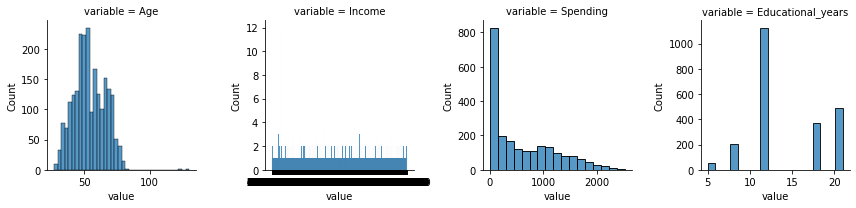

In [9]:
df = pd.DataFrame(data = data, columns=['Age','Income','Spending','Educational_years'])
nd = pd.melt(df, value_vars=df)
n1= sns.FacetGrid(data=nd, col='variable', col_wrap = 4, sharex=False, sharey=False)
n1 = n1.map(sns.histplot, 'value')
n1

<AxesSubplot:>

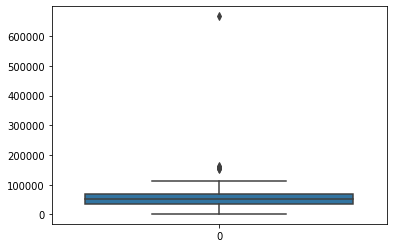

In [10]:
sns.boxplot(data = data['Income'])


**Insight:** We have a varied range of Customers in this store. People with income as high as 700k yearly income and some customers with less than $100k yearly income as well.

However, majority of customers are with low yearly income and there are only a few which have income more than $100k. This means that the store caters to majorly low-income group customers and doesn't entertain rich/luxury customers.

So, we will remove this outliers otherwise it will pose a problem in further analysis. We use the log transformation technqiue for this.

In [11]:
df = data[['Age','Income','Spending','Educational_years']]

fig = px.box(df.melt(), y="value", facet_col="variable",facet_col_wrap=2, boxmode="overlay", color="variable",height=1000, width=900)
fig.update_yaxes(matches=None)

for i in range(len(fig["data"])):
    yaxis_name = 'yaxis' if i == 0 else f'yaxis{i + 1}'
    fig.layout[yaxis_name].showticklabels = True

fig.update_layout(showlegend=False)
fig.update_xaxes(showline=True, linewidth=2, linecolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='grey')

fig.show()

Outliers analysis must be done with care. From above we can see that several variables seem to have outliers :

>Age: 3 customers older than the Upper Fence set at 74 years old. We will remove them

>Income : Several value are greater than the Upper Fence of 113K. While having an income of 150k is not impossible, we will remove the customer who has an income of 666k (Moreover, this observation is defined as an extreme outlier based on our definition stated previously)

>Spending : There is only one outlier which is at the limit of the Upper Fence. We will not remove it

In [12]:
# we must remove the outliers before processing the data
dataset = data.drop(data[data['Age'] > 83].index).reset_index(drop=True)
dataset

,Age,Income,Spending,Marital_Situation,Has_child,Educational_years,Education
0,53,84835.00,1190,Alone,No,12,Graduation
1,62,57091.00,577,Alone,No,12,Graduation
2,65,67267.00,251,In couple,Yes,12,Graduation
3,56,32474.00,11,In couple,Yes,12,Graduation
4,34,21474.00,91,Alone,Yes,12,Graduation
...,...,...,...,...,...,...,...
2232,47,66476.00,689,Alone,Yes,21,PhD
2233,46,31056.00,55,In couple,Yes,8,2n Cycle
2234,47,46310.00,309,Alone,Yes,12,Graduation
2235,45,65819.00,1383,In couple,No,12,Graduation


In [13]:
imputer = KNNImputer()
imputer = KNNImputer(n_neighbors=5, metric='nan_euclidean')
imputer.fit(dataset[['Income', 'Age', 'Educational_years']])
X = imputer.transform(dataset[['Income', 'Age', 'Educational_years']])
Income_impute=pd.DataFrame(X,columns=['Income','Age','Educational_years'])
dataset['Income']=Income_impute['Income'].reset_index(drop=True)
count_nan = len(dataset) - dataset.count()
print(count_nan)

Age                  0
Income               0
Spending             0
Marital_Situation    0
Has_child            0
Educational_years    0
Education            0
dtype: int64


We don't have any missing value

# **3. Statistical Hypothesis Testing**

### **We have 3 business problems to answer usuing Hypothesis Testing:**

1. Is the average salary of PhD owners statistically different from Master owners?

2. Is the correlation between the annual income and the amount of spending statistically significant?

3. Is there correlation between the diploma owned and the marital status?

Before running any hypothesis test, it's important to know which statistical method we should use. Statstical methods are divided in two parts :

* Parametric statistical methods

* Nonparametric statistical methods

To know which one to use, normality tests must be done on our data. If our data have a known and specific distribution, such as the Gaussian distribution; parametric statistical methods must be used. On the contrary, if data are not Gaussian, nonparametric statistical methods should be used.

There are two main ways to know if our data are Gaussian :

* Graphical methods
    * Histogram plot
    * QQ plot

* Statistical methods
    * Shapiro test
    * D'Agostino and Pearson test
    * Anderson-Darling test
    * Kolmogorov-Smirnov test
    


**Graphical methods** are mainly used for qualifying deviations from normality

**Statistical** methods are mainly used for quantifying deviations from normality

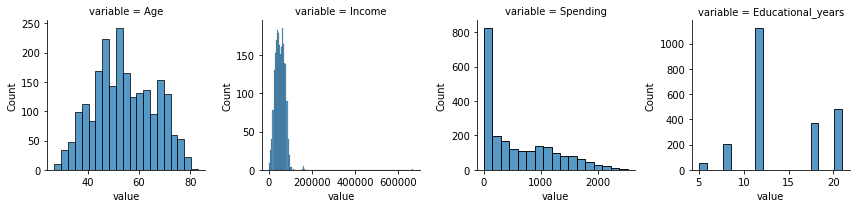

In [14]:
df = pd.DataFrame(data=dataset, columns=['Age','Income','Spending','Educational_years'])
nd = pd.melt(df, value_vars =df )
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.histplot, 'value')
n1

**Shapiro Test**

In [15]:
X=['Age','Income','Spending','Educational_years']
column_dict = {'elem':pd.DataFrame  for elem in X}
column_dict

{'elem': pandas.core.frame.DataFrame}

In [16]:
def shapiro_test(data):
    stat,p = shapiro(data)
    print('%s : Statistics=%.3f, p=%.3f' % (column,stat, p))
    alpha = 0.05
    if p > alpha:
        print("Sample Looks Gaussian - H0 not rejected")
    else:
        print("Sample is not gaussian - Look for alternative")
for column in X:
    column_dict[column] = dataset[column]
    shapiro_test(column_dict[column])

Age : Statistics=0.983, p=0.000
Sample is not gaussian - Look for alternative
Income : Statistics=0.777, p=0.000
Sample is not gaussian - Look for alternative
Spending : Statistics=0.865, p=0.000
Sample is not gaussian - Look for alternative
Educational_years : Statistics=0.832, p=0.000
Sample is not gaussian - Look for alternative


### **Rank Significance Tests**

#### **Numerical variables : Mann-Whitney's test**

Our first question was to find if the average income of PhD owners is statistically different from the average income of Master owners.

1. Hypothesis statement

**H_0** : The mean ranks of the two groups are equal

**H_a** : The mean ranks of the two groups are not equal

2. Analysis plan formulation

Significance level : We will test our hypothesis at a 5% significance level

In [17]:
#Creation of the samples
Diploma=dataset[['Education','Income']]

Phd_graduate=Diploma[Diploma['Education']=='PhD']
Master_graduate=Diploma[Diploma['Education']=='Master']
Basic_graduate=Diploma[Diploma['Education']=='Basic']
Second_cycle_graduate=Diploma[Diploma['Education']=='2n Cycle']
Graduation_graduate=Diploma[Diploma['Education']=='Graduation']

In [18]:
# normality tests of our two samples
stat, p = shapiro(Phd_graduate.Income)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.943, p=0.000
Sample does not look Gaussian (reject H0)


In [19]:
stat, p = shapiro(Master_graduate.Income)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.978, p=0.000
Sample does not look Gaussian (reject H0)


In [20]:
# summarize
print('PhD: median = %.0f stdv = %.1f' % (median(Phd_graduate.Income), std(Phd_graduate.Income)))
print('Master: median = %.0f stdv = %.1f' % (median(Master_graduate.Income), std(Master_graduate.Income)))

print(stats.mannwhitneyu(Phd_graduate.Income, Master_graduate.Income))
if p > alpha:
	print('Means are not statistically different (We fail to reject H0)')
else:
	print('Means are statistically different (We reject H0)') 

PhD: median = 55212 stdv = 20480.4
Master: median = 50943 stdv = 20021.3
MannwhitneyuResult(statistic=82012.5, pvalue=0.015561130512376573)
Means are statistically different (We reject H0)


#### Numerical variables : Spearman Rank Correlation test

The following formula is used to calculate the Spearman rank correlation:

![](https://cdn.questionpro.com/userimages/help_file_images/682/help-682-1.png)


Rs = Spearman rank correlation

D = the difference between the ranks of corresponding variables

n = number of observations

Our second question was to find if there is a statistically significant correlation between the income and the spending amount.

#### 1. Hypothesis statement  
* __H_0__ : There is no monotonic association between income and spending amount  
* __H_a__ : There is a monotonic association between income and spending amount

#### 2. Analysis plan formulation  
* __Significance level__ : We will test our hypothesis at 5% significance level  
* __Test method__ : We use the Spearman rank correlation test to determine if our two variables are correlated. This statistical method quantifies the degree to which ranked variables are associated by a monotonic function, meaning an increasing or decreasing relationship. As a statistical hypothesis test, the method assumes that the samples are uncorrelated (fail to reject H0).  
Therefore, if our assumption is correct, the result of the test should enable us to reject the null hypothesis.

In [21]:
sample = dataset[['Spending', 'Income']]
corr,pval = stats.spearmanr(sample['Spending'],sample['Income'])
print("Non-parametric correlationship test: corr coefficient: %.4f, p_value: %.4f" %(corr, pval))

Non-parametric correlationship test: corr coefficient: 0.8459, p_value: 0.0000


#### **Categorical variables : Chi-square test for independance**

Our third question was to find if there is a statistically significant correlation between the diploma and the marital situation.


#### 1. Hypothesis statement
*H_0*  : Education and Marital_Situation are independent  
*H_a*  : Education and Marital_Situation are not independent

#### 2. Analysis plan formulation  
* __Significance level__ : We will test our hypothesis at a 5% significance level  
* __Test method__ : We use the Chi-square test for independence to determine whether there is a significant relationship between our two categorical variables.

In [22]:
Marital_Situation=dataset[['Education','Marital_Situation']]
crosstab = pd.crosstab(Marital_Situation["Education"], Marital_Situation["Marital_Situation"])
crosstab

Marital_Situation,Alone,In couple
Education,,
2n Cycle,63,138
Basic,20,34
Graduation,408,719
Master,126,244
PhD,177,308


In [23]:
stat, p, dof, expected = chi2_contingency(crosstab)
print('Degress of freedom = %d' % dof)

Degress of freedom = 4


In [24]:
print(expected)


[[ 71.34286992 129.65713008]
 [ 19.16674117  34.83325883]
 [400.01698704 726.98301296]
 [131.32767099 238.67232901]
 [172.14573089 312.85426911]]
